## Final Project Submission

Please fill out:
* Student name: Guofa Shou
* Student pace: self paced
* Scheduled project review date/time: 
* Instructor name: 
* Blog post URL:


# Business Understanding
I firstly do the business understanding by the following questions and answers

In [1]:
# Q: Who are the stakeholders in this project? Who will be directly affected by the creation of this project?
# A: The stakeholders are the house buyer or seller. 
#         For house buyer, they will know the price of the house based on the characteristics,
#         and also, what's the investment value for the house
#         For house seller, they may know whether they can somehouse do something to sell the house with a better price

# Q: What business problem(s) will this Data Science project solve for the organization?
# A: A linear regression model will be built based on related features, which could predict the house price

# Q: What data sources are available to us?
# A: We have the kc_house_data.csv which includes many characteristics of the house

# Data Understanding
Now, I import the data and examine what data are available.

In [2]:
# import necessary libraries
# Warning off
import warnings
warnings.filterwarnings('ignore')

# import pandas and numpy
import pandas as pd
import numpy as np

# import data visualization
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style('darkgrid')
%matplotlib inline

# import linear regression related modules
from statsmodels.formula.api import ols
from statsmodels.stats.outliers_influence import variance_inflation_factor
import statsmodels.api as sm
import scipy.stats as stats
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split


In [3]:
# loading kc_house_data.csv data
df = pd.read_csv('./data/kc_house_data.csv')
df.head() # checking the head for information

,id,date,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,...,grade,sqft_above,sqft_basement,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15
0,7129300520,10/13/2014,221900.0,3,1.00,1180,5650,1.0,NaN,0.0,...,7,1180,0.0,1955,0.0,98178,47.5112,-122.257,1340,5650
1,6414100192,12/9/2014,538000.0,3,2.25,2570,7242,2.0,0.0,0.0,...,7,2170,400.0,1951,1991.0,98125,47.7210,-122.319,1690,7639
2,5631500400,2/25/2015,180000.0,2,1.00,770,10000,1.0,0.0,0.0,...,6,770,0.0,1933,NaN,98028,47.7379,-122.233,2720,8062
3,2487200875,12/9/2014,604000.0,4,3.00,1960,5000,1.0,0.0,0.0,...,7,1050,910.0,1965,0.0,98136,47.5208,-122.393,1360,5000
4,1954400510,2/18/2015,510000.0,3,2.00,1680,8080,1.0,0.0,0.0,...,8,1680,0.0,1987,0.0,98074,47.6168,-122.045,1800,7503


In [4]:
# Describe the dataset using 5-point statistics
df.describe()
# What data is available to us?
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 21597 entries, 0 to 21596
Data columns (total 21 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   id             21597 non-null  int64  
 1   date           21597 non-null  object 
 2   price          21597 non-null  float64
 3   bedrooms       21597 non-null  int64  
 4   bathrooms      21597 non-null  float64
 5   sqft_living    21597 non-null  int64  
 6   sqft_lot       21597 non-null  int64  
 7   floors         21597 non-null  float64
 8   waterfront     19221 non-null  float64
 9   view           21534 non-null  float64
 10  condition      21597 non-null  int64  
 11  grade          21597 non-null  int64  
 12  sqft_above     21597 non-null  int64  
 13  sqft_basement  21597 non-null  object 
 14  yr_built       21597 non-null  int64  
 15  yr_renovated   17755 non-null  float64
 16  zipcode        21597 non-null  int64  
 17  lat            21597 non-null  float64
 18  long  

In [5]:
# We have potentially 19 predictors excluding the id and the target,i.e.,the price
# We have a total of 21597 rows, while some rows have null values in some predictors
# Several predictors' data type need to be changed

# Data Preparation
Deal with data types and missing data

### Deal with data types: sqft_basement & date

In [6]:
# sqft_basement: Numerical Data Stored as Strings need to be reformat to float
print(df.sqft_basement.unique())
df.sqft_basement.value_counts()
# there is '?' in the sqft_basement, need to be repalce as nan before reformat to float
df.sqft_basement = df.sqft_basement.map(lambda x: float(x.replace('?', 'nan')))
df.sqft_basement.unique()

['0.0' '400.0' '910.0' '1530.0' '?' '730.0' '1700.0' '300.0' '970.0'
 '760.0' '720.0' '700.0' '820.0' '780.0' '790.0' '330.0' '1620.0' '360.0'
 '588.0' '1510.0' '410.0' '990.0' '600.0' '560.0' '550.0' '1000.0'
 '1600.0' '500.0' '1040.0' '880.0' '1010.0' '240.0' '265.0' '290.0'
 '800.0' '540.0' '710.0' '840.0' '380.0' '770.0' '480.0' '570.0' '1490.0'
 '620.0' '1250.0' '1270.0' '120.0' '650.0' '180.0' '1130.0' '450.0'
 '1640.0' '1460.0' '1020.0' '1030.0' '750.0' '640.0' '1070.0' '490.0'
 '1310.0' '630.0' '2000.0' '390.0' '430.0' '850.0' '210.0' '1430.0'
 '1950.0' '440.0' '220.0' '1160.0' '860.0' '580.0' '2060.0' '1820.0'
 '1180.0' '200.0' '1150.0' '1200.0' '680.0' '530.0' '1450.0' '1170.0'
 '1080.0' '960.0' '280.0' '870.0' '1100.0' '460.0' '1400.0' '660.0'
 '1220.0' '900.0' '420.0' '1580.0' '1380.0' '475.0' '690.0' '270.0'
 '350.0' '935.0' '1370.0' '980.0' '1470.0' '160.0' '950.0' '50.0' '740.0'
 '1780.0' '1900.0' '340.0' '470.0' '370.0' '140.0' '1760.0' '130.0'
 '520.0' '890.0' '1110.0'

array([   0.,  400.,  910., 1530.,   nan,  730., 1700.,  300.,  970.,
        760.,  720.,  700.,  820.,  780.,  790.,  330., 1620.,  360.,
        588., 1510.,  410.,  990.,  600.,  560.,  550., 1000., 1600.,
        500., 1040.,  880., 1010.,  240.,  265.,  290.,  800.,  540.,
        710.,  840.,  380.,  770.,  480.,  570., 1490.,  620., 1250.,
       1270.,  120.,  650.,  180., 1130.,  450., 1640., 1460., 1020.,
       1030.,  750.,  640., 1070.,  490., 1310.,  630., 2000.,  390.,
        430.,  850.,  210., 1430., 1950.,  440.,  220., 1160.,  860.,
        580., 2060., 1820., 1180.,  200., 1150., 1200.,  680.,  530.,
       1450., 1170., 1080.,  960.,  280.,  870., 1100.,  460., 1400.,
        660., 1220.,  900.,  420., 1580., 1380.,  475.,  690.,  270.,
        350.,  935., 1370.,  980., 1470.,  160.,  950.,   50.,  740.,
       1780., 1900.,  340.,  470.,  370.,  140., 1760.,  130.,  520.,
        890., 1110.,  150., 1720.,  810.,  190., 1290.,  670., 1800.,
       1120., 1810.,

In [7]:
# For the sold date, since day is not important for the regression model,
# I only extract year and month for the sold date, and add two columns as year_sold and month_sold
df['year_sold'] = pd.DatetimeIndex(df['date']).year
df['month_sold'] = pd.DatetimeIndex(df['date']).month

# Based on the yr_built and month_sold, I create another column as age_sold of the house
df['age_sold'] = df['year_sold'] - df['yr_built'] + 1
df.head()

,id,date,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,...,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15,year_sold,month_sold,age_sold
0,7129300520,10/13/2014,221900.0,3,1.00,1180,5650,1.0,NaN,0.0,...,1955,0.0,98178,47.5112,-122.257,1340,5650,2014,10,60
1,6414100192,12/9/2014,538000.0,3,2.25,2570,7242,2.0,0.0,0.0,...,1951,1991.0,98125,47.7210,-122.319,1690,7639,2014,12,64
2,5631500400,2/25/2015,180000.0,2,1.00,770,10000,1.0,0.0,0.0,...,1933,NaN,98028,47.7379,-122.233,2720,8062,2015,2,83
3,2487200875,12/9/2014,604000.0,4,3.00,1960,5000,1.0,0.0,0.0,...,1965,0.0,98136,47.5208,-122.393,1360,5000,2014,12,50
4,1954400510,2/18/2015,510000.0,3,2.00,1680,8080,1.0,0.0,0.0,...,1987,0.0,98074,47.6168,-122.045,1800,7503,2015,2,29


### Deal with null values

In [8]:
# Get the percentage value of null data for each column
df.isnull().sum()*100/df.shape[0]

id                0.000000
date              0.000000
price             0.000000
bedrooms          0.000000
bathrooms         0.000000
sqft_living       0.000000
sqft_lot          0.000000
floors            0.000000
waterfront       11.001528
view              0.291707
condition         0.000000
grade             0.000000
sqft_above        0.000000
sqft_basement     2.102144
yr_built          0.000000
yr_renovated     17.789508
zipcode           0.000000
lat               0.000000
long              0.000000
sqft_living15     0.000000
sqft_lot15        0.000000
year_sold         0.000000
month_sold        0.000000
age_sold          0.000000
dtype: float64

<class 'pandas.core.frame.DataFrame'>
Int64Index: 21082 entries, 0 to 21596
Data columns (total 25 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   id             21082 non-null  int64  
 1   date           21082 non-null  object 
 2   price          21082 non-null  float64
 3   bedrooms       21082 non-null  int64  
 4   bathrooms      21082 non-null  float64
 5   sqft_living    21082 non-null  int64  
 6   sqft_lot       21082 non-null  int64  
 7   floors         21082 non-null  float64
 8   waterfront     21082 non-null  float64
 9   view           21082 non-null  float64
 10  condition      21082 non-null  int64  
 11  grade          21082 non-null  int64  
 12  sqft_above     21082 non-null  int64  
 13  sqft_basement  21082 non-null  float64
 14  yr_built       21082 non-null  int64  
 15  yr_renovated   21082 non-null  float64
 16  zipcode        21082 non-null  int64  
 17  lat            21082 non-null  float64
 18  long  

0.0    20360
1.0      722
Name: is_renovated, dtype: int64

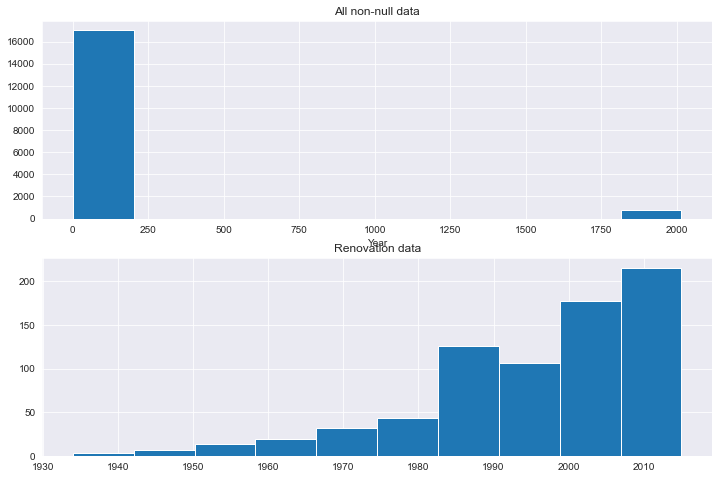

In [9]:
# There are some null data in waterfront, view, yr_renovated, sqft_basement
# 1) since the percentage of null data in view is low, I just drop these rows
# 2) For waterfront and yr_renovated, the percentage of null data is high,I will assign another value there

# waterfront is a categorical variable
df.waterfront.value_counts()
# replace nan as a value: 
# Originally I used 2.0 as a third category, 
# but late I found the price for this missing data is similar as for waterfront == 0
# Therefore, I fill the null as 0
df.waterfront = df.waterfront.fillna(0)
df.waterfront.value_counts()

# yr_renovated has 17011/17755~96% without renovation, 
#  and only 4% with renovation based on the non-null data
df.yr_renovated.value_counts()
# take a look of histogram
fig, axs = plt.subplots(2,figsize=(12,8))
df['yr_renovated'].hist(ax = axs[0]);
axs[0].set_title('All non-null data')
axs[0].set_xlabel('Year')
# with renovation
df[df.yr_renovated > 0].yr_renovated.hist(ax = axs[1])
# dfwrenov['yr_renovated'].hist(ax = axs[1]);
axs[1].set_title('Renovation data')
axs[0].set_xlabel('Year')
# Based on renovated data, I create a caterogrial variable as is_renovated

ds_renovated = df['yr_renovated']
ds_renovated[ds_renovated >0] = 1
# replace nan as a value: 
# Originally I used 2.0 as a third category, 
# but late I found the price for this missing data is similar as for is_renovated == 0
# Therefore, I fill the null as 0
ds_renovated = ds_renovated.fillna(0)
ds_renovated
df['is_renovated'] = ds_renovated
del ds_renovated
df.is_renovated.value_counts()
# assign as -1 to make sure these rows are not dropped in the following operation
df.yr_renovated = df.yr_renovated.fillna(-1)
# for view and sqft_basement, I just drop those rows with null value, since they are only a few
df.dropna(inplace=True)
print(df.info())
print(df.shape)
df.is_renovated.value_counts()

### Deal with outliers if existed in some columns

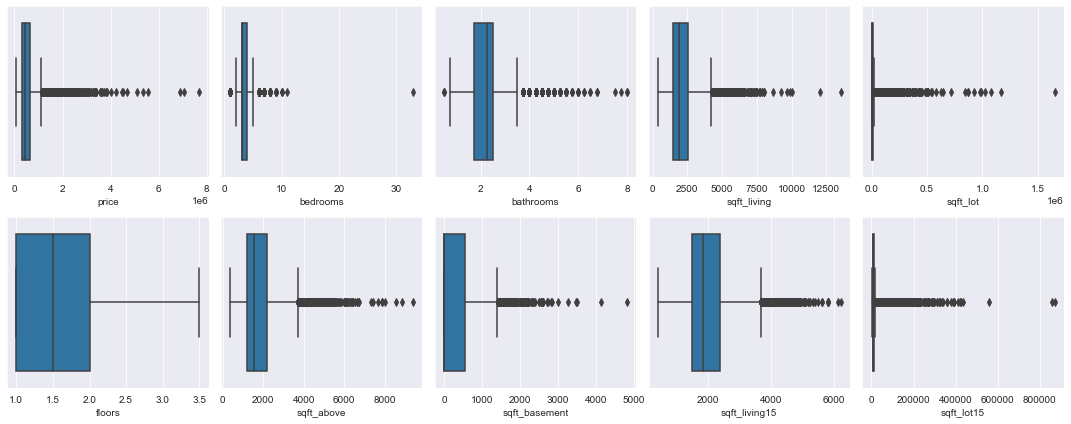

In [10]:
# For some selected columns, have a boxplot to examine the outliers
x_cols = ['price','bedrooms','bathrooms','sqft_living','sqft_lot',
          'floors','sqft_above','sqft_basement','sqft_living15','sqft_lot15']
fig, axs = plt.subplots(2,5, figsize = (15,6))
for colii in range(len(x_cols)):
    sns.boxplot(df[x_cols[colii]],ax = axs[colii//5, colii%5])
plt.tight_layout()

In [11]:
# process of outliers:
# It seems all these items except floors have outliers
# I will drop the outliers as there are sufficient data

x_cols = ['price','bedrooms','bathrooms','sqft_living','sqft_lot',
          'sqft_above','sqft_basement','sqft_living15','sqft_lot15']

for colname in x_cols:
    Q1 = df[colname].quantile(0.25)
    Q3 = df[colname].quantile(0.75)
    IQR = Q3 - Q1
    lenori = len(df[colname])
    df = df[(df[colname] >= Q1 - 1.5*IQR) & (df[colname] <= Q3 + 1.5*IQR)]
    lennew = len(df[colname])
    print(f'Number of rows based on {colname} : {lenori} -> {lennew}')

Number of rows based on price : 21082 -> 19951
Number of rows based on bedrooms : 19951 -> 19502
Number of rows based on bathrooms : 19502 -> 19437
Number of rows based on sqft_living : 19437 -> 19181
Number of rows based on sqft_lot : 19181 -> 17163
Number of rows based on sqft_above : 17163 -> 16697
Number of rows based on sqft_basement : 16697 -> 16401
Number of rows based on sqft_living15 : 16401 -> 16195
Number of rows based on sqft_lot15 : 16195 -> 15831


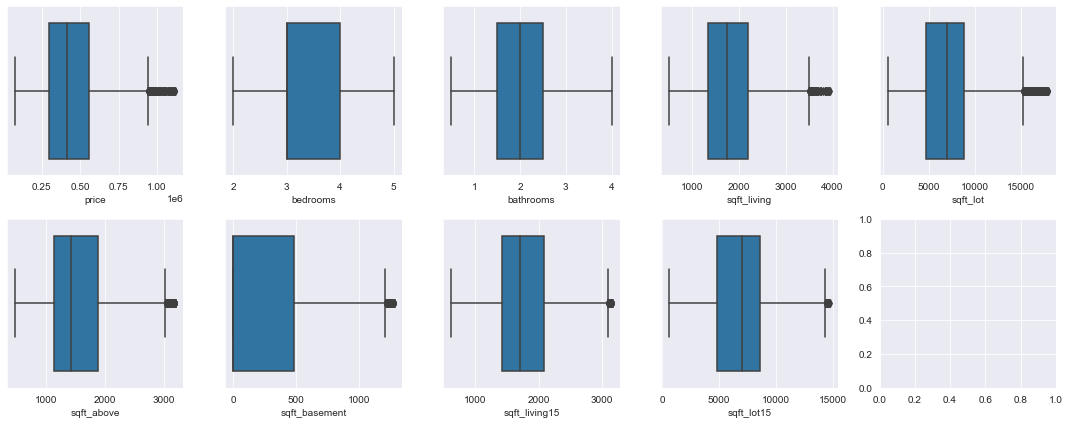

In [12]:
# boxplot for the remaining data
fig, axs = plt.subplots(2,5, figsize = (15,6))
for colii in range(len(x_cols)):
    sns.boxplot(df[x_cols[colii]],ax = axs[colii//5, colii%5])
plt.tight_layout()
# now looks all good

0.0    15818
1.0       13
Name: waterfront, dtype: int64
3    10263
4     4160
5     1283
2      110
1       15
Name: condition, dtype: int64
0.0    15385
1.0      446
Name: is_renovated, dtype: int64


2.50    3954
1.00    3296
1.75    2464
2.00    1590
2.25    1558
1.50    1254
2.75     702
3.00     431
3.50     271
3.25     226
3.75      28
0.75      28
4.00      21
1.25       6
0.50       2
Name: bathrooms, dtype: int64

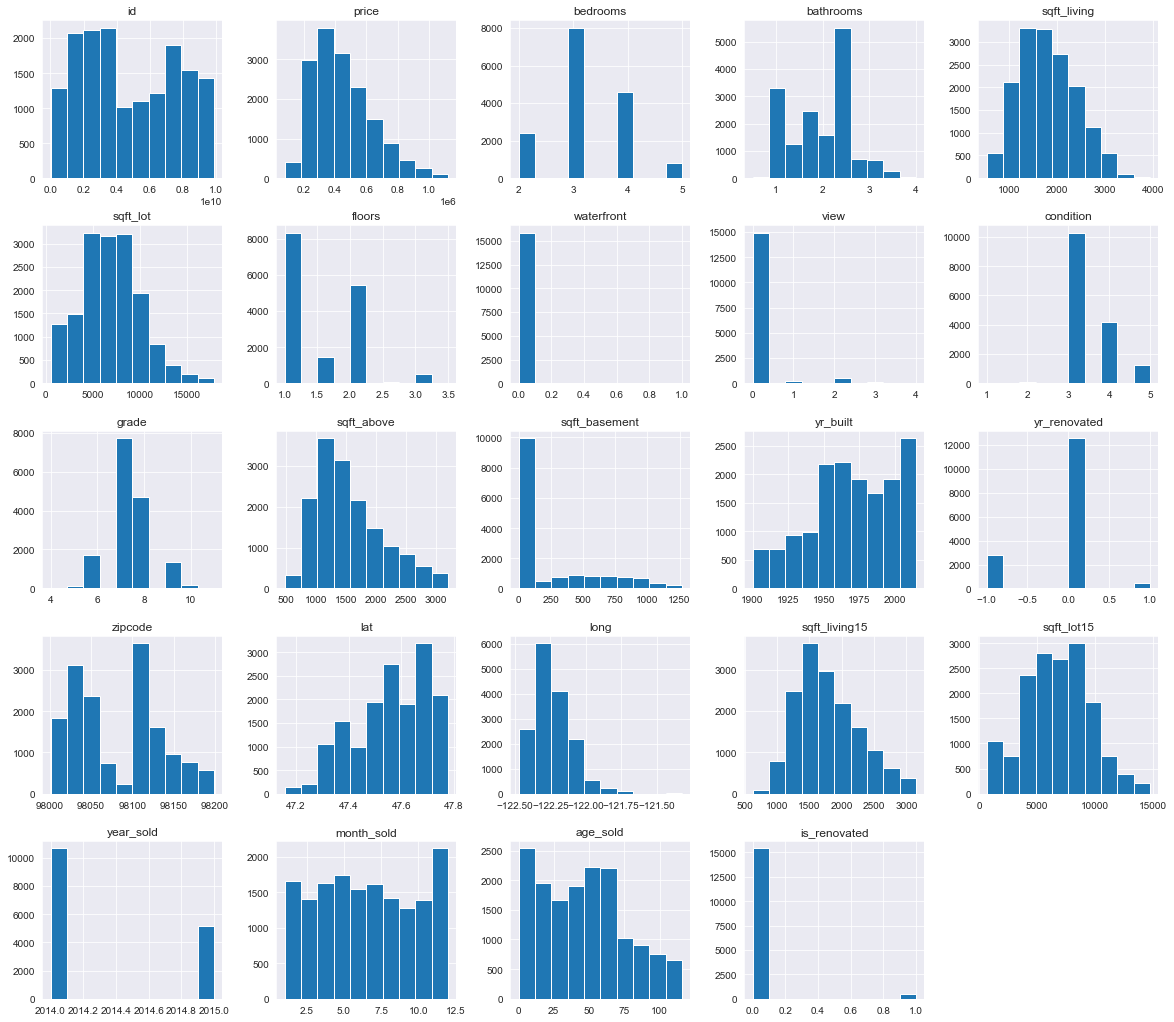

In [13]:
# visualization of the final data
# with its histogram:
df.hist(figsize = (20,18));
print(df.waterfront.value_counts())
print(df.condition.value_counts())
print(df.is_renovated.value_counts())
# looks good
df.bathrooms.value_counts()

In [14]:
# df.zipcode.value_counts()
# I only keep the first four digits since if I only keep the first three digits,it will only have two zipcodes
df['zipcode4'] = df.zipcode//10 * 10
df.zipcode4.value_counts()

98110    2051
98050    1831
98030    1767
98100    1594
98000    1488
98020    1243
98120     931
98130     689
98040     629
98140     588
98070     524
98190     465
98170     407
98160     369
98150     366
98010     337
98090     229
98060     209
98180     114
Name: zipcode4, dtype: int64

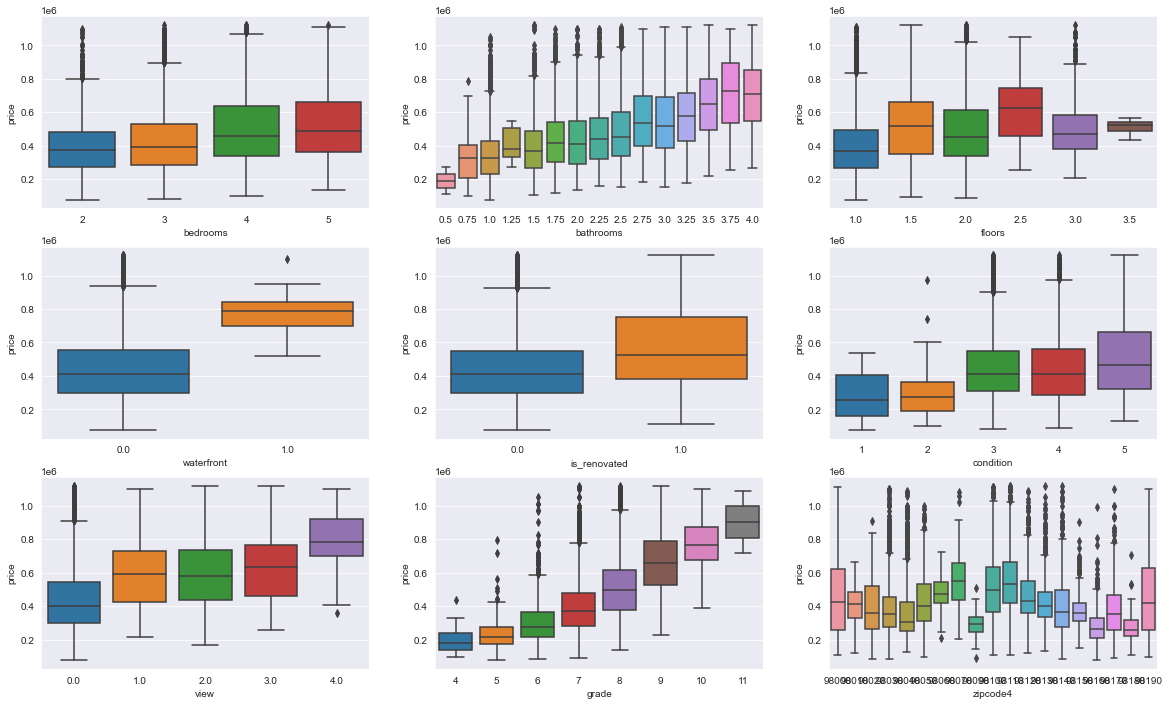

In [15]:
# visualization of categorical variables 
cat_vars = ['bedrooms','bathrooms','floors','waterfront','is_renovated','condition','view','grade','zipcode4']
plt.figure(figsize=(20, 12))
for idx in range(len(cat_vars)):
    plt.subplot(3,3,idx+1)
    sns.boxplot(x = cat_vars[idx], y = 'price', data = df)

In [16]:
# For all these categorical variables, I implemented the one hot encoding .get_dummies() method
# and drop one column for redundant information
for cat_var in cat_vars:
# cat_var = cat_vars[0]
    tmp_dums = pd.get_dummies(df[cat_var], prefix=cat_var)
    print(tmp_dums.head())
    del tmp_dums[tmp_dums.columns[0]]
    print(tmp_dums.head())    
    df = pd.concat([df,tmp_dums],axis = 1)
    del tmp_dums
df.head()


   bedrooms_2  bedrooms_3  bedrooms_4  bedrooms_5
0           0           1           0           0
1           0           1           0           0
2           1           0           0           0
3           0           0           1           0
4           0           1           0           0
   bedrooms_3  bedrooms_4  bedrooms_5
0           1           0           0
1           1           0           0
2           0           0           0
3           0           1           0
4           1           0           0
   bathrooms_0.5  bathrooms_0.75  bathrooms_1.0  bathrooms_1.25  \
0              0               0              1               0   
1              0               0              0               0   
2              0               0              1               0   
3              0               0              0               0   
4              0               0              0               0   

   bathrooms_1.5  bathrooms_1.75  bathrooms_2.0  bathrooms_2.25  \
0 

,id,date,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,...,zipcode4_98100,zipcode4_98110,zipcode4_98120,zipcode4_98130,zipcode4_98140,zipcode4_98150,zipcode4_98160,zipcode4_98170,zipcode4_98180,zipcode4_98190
0,7129300520,10/13/2014,221900.0,3,1.00,1180,5650,1.0,0.0,0.0,...,0,0,0,0,0,0,0,1,0,0
1,6414100192,12/9/2014,538000.0,3,2.25,2570,7242,2.0,0.0,0.0,...,0,0,1,0,0,0,0,0,0,0
2,5631500400,2/25/2015,180000.0,2,1.00,770,10000,1.0,0.0,0.0,...,0,0,0,0,0,0,0,0,0,0
3,2487200875,12/9/2014,604000.0,4,3.00,1960,5000,1.0,0.0,0.0,...,0,0,0,1,0,0,0,0,0,0
4,1954400510,2/18/2015,510000.0,3,2.00,1680,8080,1.0,0.0,0.0,...,0,0,0,0,0,0,0,0,0,0


# Modeling
After finishing the data preparation, now I start to build the regression model

In [17]:
# drop id, date, yr_renovated,lat, long, zipcode from df
# the id has not related to the house price
# the date has been transformed into sold_year and sold_month
# the yr_renovated has been transformed into is_renovated
# the lat and long indicate similar information as zipcode
# zipcode has been transformed into zipcode4 and dummy variables
# I keep zipcode4 try to take a look which one is better based on either zipcode4 or zipcode_dummies
drop_vars = ['id','date','yr_renovated','lat','long','zipcode']
df.drop(drop_vars, axis = 1, inplace = True)
print(df.head())
# drop all caterogical variables
df.drop(cat_vars, axis = 1, inplace = True)
df.head()

      price  bedrooms  bathrooms  sqft_living  sqft_lot  floors  waterfront  \
0  221900.0         3       1.00         1180      5650     1.0         0.0   
1  538000.0         3       2.25         2570      7242     2.0         0.0   
2  180000.0         2       1.00          770     10000     1.0         0.0   
3  604000.0         4       3.00         1960      5000     1.0         0.0   
4  510000.0         3       2.00         1680      8080     1.0         0.0   

   view  condition  grade  ...  zipcode4_98100  zipcode4_98110  \
0   0.0          3      7  ...               0               0   
1   0.0          3      7  ...               0               0   
2   0.0          3      6  ...               0               0   
3   0.0          5      7  ...               0               0   
4   0.0          3      8  ...               0               0   

   zipcode4_98120  zipcode4_98130  zipcode4_98140  zipcode4_98150  \
0               0               0               0          

,price,sqft_living,sqft_lot,sqft_above,sqft_basement,yr_built,sqft_living15,sqft_lot15,year_sold,month_sold,...,zipcode4_98100,zipcode4_98110,zipcode4_98120,zipcode4_98130,zipcode4_98140,zipcode4_98150,zipcode4_98160,zipcode4_98170,zipcode4_98180,zipcode4_98190
0,221900.0,1180,5650,1180,0.0,1955,1340,5650,2014,10,...,0,0,0,0,0,0,0,1,0,0
1,538000.0,2570,7242,2170,400.0,1951,1690,7639,2014,12,...,0,0,1,0,0,0,0,0,0,0
2,180000.0,770,10000,770,0.0,1933,2720,8062,2015,2,...,0,0,0,0,0,0,0,0,0,0
3,604000.0,1960,5000,1050,910.0,1965,1360,5000,2014,12,...,0,0,0,1,0,0,0,0,0,0
4,510000.0,1680,8080,1680,0.0,1987,1800,7503,2015,2,...,0,0,0,0,0,0,0,0,0,0


In [18]:
# transform column names as string
df.columns = df.columns.astype(str)
df.head()

,price,sqft_living,sqft_lot,sqft_above,sqft_basement,yr_built,sqft_living15,sqft_lot15,year_sold,month_sold,...,zipcode4_98100,zipcode4_98110,zipcode4_98120,zipcode4_98130,zipcode4_98140,zipcode4_98150,zipcode4_98160,zipcode4_98170,zipcode4_98180,zipcode4_98190
0,221900.0,1180,5650,1180,0.0,1955,1340,5650,2014,10,...,0,0,0,0,0,0,0,1,0,0
1,538000.0,2570,7242,2170,400.0,1951,1690,7639,2014,12,...,0,0,1,0,0,0,0,0,0,0
2,180000.0,770,10000,770,0.0,1933,2720,8062,2015,2,...,0,0,0,0,0,0,0,0,0,0
3,604000.0,1960,5000,1050,910.0,1965,1360,5000,2014,12,...,0,0,0,1,0,0,0,0,0,0
4,510000.0,1680,8080,1680,0.0,1987,1800,7503,2015,2,...,0,0,0,0,0,0,0,0,0,0


In [19]:
# Rescaling the features except the 'dummy' variable
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()
num_vars = list(['sqft_living','sqft_lot', 'sqft_above', 'sqft_basement', 'yr_built', 
       'sqft_living15', 'sqft_lot15', 'year_sold','age_sold',
       'month_sold'])
df_scl = df
df_scl[num_vars] = scaler.fit_transform(df[num_vars])
df_scl.head()

,price,sqft_living,sqft_lot,sqft_above,sqft_basement,yr_built,sqft_living15,sqft_lot15,year_sold,month_sold,...,zipcode4_98100,zipcode4_98110,zipcode4_98120,zipcode4_98130,zipcode4_98140,zipcode4_98150,zipcode4_98160,zipcode4_98170,zipcode4_98180,zipcode4_98190
0,221900.0,0.192982,0.295865,0.257353,0.000000,0.478261,0.284585,0.354992,0.0,0.818182,...,0,0,0,0,0,0,0,1,0,0
1,538000.0,0.599415,0.387681,0.621324,0.314961,0.443478,0.422925,0.496236,0.0,1.000000,...,0,0,1,0,0,0,0,0,0,0
2,180000.0,0.073099,0.546744,0.106618,0.000000,0.286957,0.830040,0.526275,1.0,0.090909,...,0,0,0,0,0,0,0,0,0,0
3,604000.0,0.421053,0.258377,0.209559,0.716535,0.565217,0.292490,0.308834,0.0,1.000000,...,0,0,0,1,0,0,0,0,0,0
4,510000.0,0.339181,0.436011,0.441176,0.000000,0.756522,0.466403,0.486579,1.0,0.090909,...,0,0,0,0,0,0,0,0,0,0


In [20]:
df_scl.columns

Index(['price', 'sqft_living', 'sqft_lot', 'sqft_above', 'sqft_basement',
       'yr_built', 'sqft_living15', 'sqft_lot15', 'year_sold', 'month_sold',
       'age_sold', 'bedrooms_3', 'bedrooms_4', 'bedrooms_5', 'bathrooms_0.75',
       'bathrooms_1.0', 'bathrooms_1.25', 'bathrooms_1.5', 'bathrooms_1.75',
       'bathrooms_2.0', 'bathrooms_2.25', 'bathrooms_2.5', 'bathrooms_2.75',
       'bathrooms_3.0', 'bathrooms_3.25', 'bathrooms_3.5', 'bathrooms_3.75',
       'bathrooms_4.0', 'floors_1.5', 'floors_2.0', 'floors_2.5', 'floors_3.0',
       'floors_3.5', 'waterfront_1.0', 'is_renovated_1.0', 'condition_2',
       'condition_3', 'condition_4', 'condition_5', 'view_1.0', 'view_2.0',
       'view_3.0', 'view_4.0', 'grade_5', 'grade_6', 'grade_7', 'grade_8',
       'grade_9', 'grade_10', 'grade_11', 'zipcode4_98010', 'zipcode4_98020',
       'zipcode4_98030', 'zipcode4_98040', 'zipcode4_98050', 'zipcode4_98060',
       'zipcode4_98070', 'zipcode4_98090', 'zipcode4_98100', 'zipcode4_98110'


 mean = 446934.39 and std dev = 188664.37



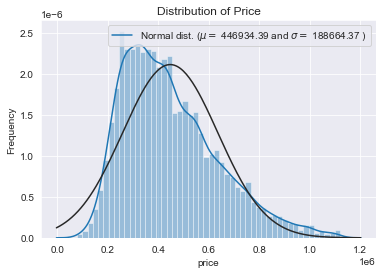

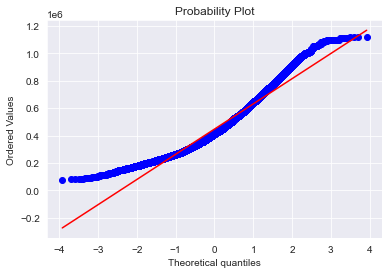

In [21]:
#Check the distribution of the target: price, to see whether it follows a normal distribution 
sns.distplot(df_scl['price'] , fit=stats.norm);

# Get the fitted parameters used by the function
(mu, sigma) = stats.norm.fit(df_scl['price'])
print( '\n mean = {:.2f} and std dev = {:.2f}\n'.format(mu, sigma))

#NPlotting the distribution
plt.legend(['Normal dist. ($\mu=$ {:.2f} and $\sigma=$ {:.2f} )'.format(mu, sigma)],
            loc='best')
plt.ylabel('Frequency')
plt.title('Distribution of Price')

#Also the QQ plot
fig = plt.figure()
res = stats.probplot(df_scl['price'], plot=plt)
plt.show()

In [22]:
# it looks the target is skewed right, therefore, I used a log transformation to make it more normal


 mean = 12.92 and std dev = 0.42



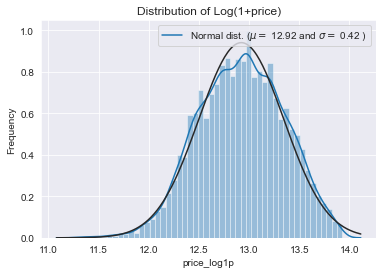

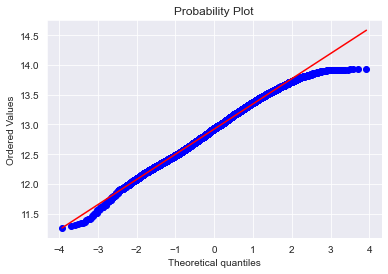

In [23]:
#Using the log1p function applies log(1+x) to all elements of the column
df_scl['price_log1p'] = np.log1p(df_scl['price'])

#Check the new distribution after log transformation 
sns.distplot(df_scl['price_log1p'] , fit=stats.norm);

# Get the fitted parameters used by the function
(mu, sigma) = stats.norm.fit(df_scl['price_log1p'])
print( '\n mean = {:.2f} and std dev = {:.2f}\n'.format(mu, sigma))

#NPlotting the distribution
plt.legend(['Normal dist. ($\mu=$ {:.2f} and $\sigma=$ {:.2f} )'.format(mu, sigma)],
            loc='best')
plt.ylabel('Frequency')
plt.title('Distribution of Log(1+price)')

#Also the QQ plot
fig = plt.figure()
res = stats.probplot(df_scl['price_log1p'], plot=plt)
plt.show()

In [24]:
# scale for the target variable
tar_vars = ['price','price_log1p']
df_scl[num_vars] = scaler.fit_transform(df[num_vars])
df_scl.head()

,price,sqft_living,sqft_lot,sqft_above,sqft_basement,yr_built,sqft_living15,sqft_lot15,year_sold,month_sold,...,zipcode4_98110,zipcode4_98120,zipcode4_98130,zipcode4_98140,zipcode4_98150,zipcode4_98160,zipcode4_98170,zipcode4_98180,zipcode4_98190,price_log1p
0,221900.0,0.192982,0.295865,0.257353,0.000000,0.478261,0.284585,0.354992,0.0,0.818182,...,0,0,0,0,0,0,1,0,0,12.309987
1,538000.0,0.599415,0.387681,0.621324,0.314961,0.443478,0.422925,0.496236,0.0,1.000000,...,0,1,0,0,0,0,0,0,0,13.195616
2,180000.0,0.073099,0.546744,0.106618,0.000000,0.286957,0.830040,0.526275,1.0,0.090909,...,0,0,0,0,0,0,0,0,0,12.100718
3,604000.0,0.421053,0.258377,0.209559,0.716535,0.565217,0.292490,0.308834,0.0,1.000000,...,0,0,1,0,0,0,0,0,0,13.311331
4,510000.0,0.339181,0.436011,0.441176,0.000000,0.756522,0.466403,0.486579,1.0,0.090909,...,0,0,0,0,0,0,0,0,0,13.142168


In [25]:
# Splitting the Data into Training and Testing
df_train, df_test = train_test_split(df, train_size = 0.8, test_size = 0.2, random_state = 100)
print(len(df_train), len(df_test))
df_train.head()
df.columns

12664 3167


Index(['price', 'sqft_living', 'sqft_lot', 'sqft_above', 'sqft_basement',
       'yr_built', 'sqft_living15', 'sqft_lot15', 'year_sold', 'month_sold',
       'age_sold', 'bedrooms_3', 'bedrooms_4', 'bedrooms_5', 'bathrooms_0.75',
       'bathrooms_1.0', 'bathrooms_1.25', 'bathrooms_1.5', 'bathrooms_1.75',
       'bathrooms_2.0', 'bathrooms_2.25', 'bathrooms_2.5', 'bathrooms_2.75',
       'bathrooms_3.0', 'bathrooms_3.25', 'bathrooms_3.5', 'bathrooms_3.75',
       'bathrooms_4.0', 'floors_1.5', 'floors_2.0', 'floors_2.5', 'floors_3.0',
       'floors_3.5', 'waterfront_1.0', 'is_renovated_1.0', 'condition_2',
       'condition_3', 'condition_4', 'condition_5', 'view_1.0', 'view_2.0',
       'view_3.0', 'view_4.0', 'grade_5', 'grade_6', 'grade_7', 'grade_8',
       'grade_9', 'grade_10', 'grade_11', 'zipcode4_98010', 'zipcode4_98020',
       'zipcode4_98030', 'zipcode4_98040', 'zipcode4_98050', 'zipcode4_98060',
       'zipcode4_98070', 'zipcode4_98090', 'zipcode4_98100', 'zipcode4_98110'

## Checking for Multicollinearity

In [26]:
print((num_vars))

['sqft_living', 'sqft_lot', 'sqft_above', 'sqft_basement', 'yr_built', 'sqft_living15', 'sqft_lot15', 'year_sold', 'age_sold', 'month_sold']


In [27]:
# Check the correlation coefficients to see which variables are highly correlated
num_vars.append('price')
num_vars.append('price_log1p')
corr = df_train[num_vars].corr()
corr

,sqft_living,sqft_lot,sqft_above,sqft_basement,yr_built,sqft_living15,sqft_lot15,year_sold,age_sold,month_sold,price,price_log1p
sqft_living,1.000000,0.171593,0.818302,0.371526,0.318520,0.695589,0.151181,-0.024536,-0.318876,0.006327,0.518899,0.517514
sqft_lot,0.171593,1.000000,0.133727,0.074555,-0.079902,0.221833,0.876250,0.003379,0.079948,-0.006723,-0.089302,-0.109111
sqft_above,0.818302,0.133727,1.000000,-0.229627,0.443562,0.670615,0.116469,-0.017244,-0.443793,-0.000200,0.399563,0.396783
sqft_basement,0.371526,0.074555,-0.229627,1.000000,-0.177117,0.094622,0.067866,-0.013693,0.176886,0.011037,0.233251,0.235396
yr_built,0.318520,-0.079902,0.443562,-0.177117,1.000000,0.321349,-0.063158,0.002188,-0.999877,-0.008915,-0.052032,-0.018664
sqft_living15,0.695589,0.221833,0.670615,0.094622,0.321349,1.000000,0.235881,-0.006656,-0.321425,-0.008937,0.442030,0.449107
sqft_lot15,0.151181,0.876250,0.116469,0.067866,-0.063158,0.235881,1.000000,0.002521,0.063192,-0.007761,-0.103846,-0.126215
year_sold,-0.024536,0.003379,-0.017244,-0.013693,0.002188,-0.006656,0.002521,1.000000,0.013503,-0.785087,0.018008,0.014647
age_sold,-0.318876,0.079948,-0.443793,0.176886,-0.999877,-0.321425,0.063192,0.013503,1.000000,-0.003405,0.052310,0.018892
month_sold,0.006327,-0.006723,-0.000200,0.011037,-0.008915,-0.008937,-0.007761,-0.785087,-0.003405,1.000000,-0.024034,-0.020060


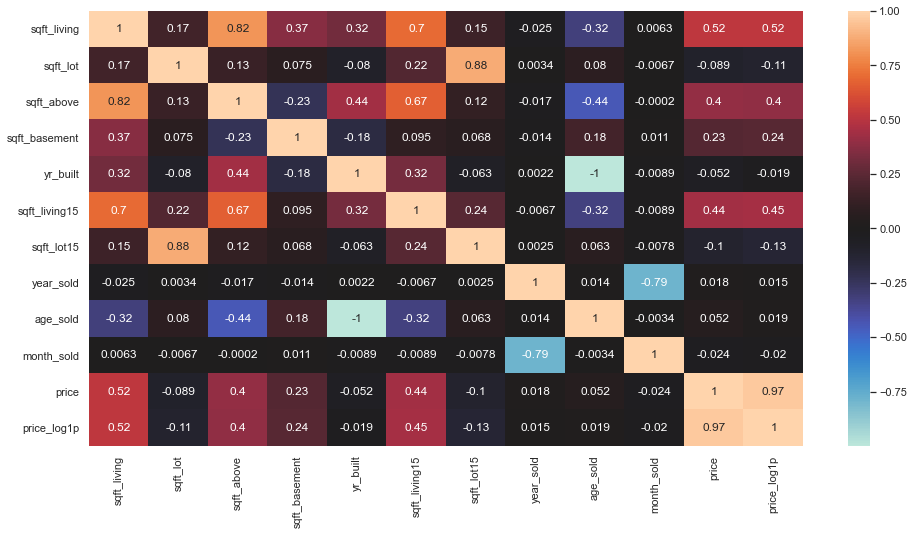

In [28]:
# Using heatmap to visualzation of the correlation coefficients
sns.set(rc = {'figure.figsize':(16,8)})
sns.heatmap(corr, center=0, annot=True);

In [29]:
# price is correlated to sqrt_living the most. 

In [30]:
# Fitting the actual model with all available features, zipcode with dummy values
import statsmodels.api as sm

# price vs price_log1p
outcome1 = 'price'
outcome2 = 'price_log1p'
x_cols = list(df_train.columns)
x_cols.remove(outcome1)
x_cols.remove(outcome2)
model1 = sm.OLS(df_train[outcome1],sm.add_constant(df_train[x_cols])).fit()
print(model1.summary())
model2 = sm.OLS(df_train[outcome2],sm.add_constant(df_train[x_cols])).fit()
print(model2.summary())


                            OLS Regression Results                            
Dep. Variable:                  price   R-squared:                       0.597
Model:                            OLS   Adj. R-squared:                  0.595
Method:                 Least Squares   F-statistic:                     291.5
Date:                Mon, 29 Nov 2021   Prob (F-statistic):               0.00
Time:                        20:17:22   Log-Likelihood:            -1.6601e+05
No. Observations:               12664   AIC:                         3.322e+05
Df Residuals:                   12599   BIC:                         3.326e+05
Df Model:                          64                                         
Covariance Type:            nonrobust                                         
                       coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------
const             1.492e+04   3.62e+04  

In [31]:
# Based on the R-squared values from two models, 
# I choose to use outcome = 'price_log1p' and zipcode_dummies for regression model
# price_log1p
outcome = 'price_log1p'
x_cols = list(df_train.columns)
x_cols.remove(outcome)
x_cols.remove('price')
model0 = sm.OLS(df_train[outcome],sm.add_constant(df_train[x_cols])).fit()
print(model0.summary())

                            OLS Regression Results                            
Dep. Variable:            price_log1p   R-squared:                       0.598
Model:                            OLS   Adj. R-squared:                  0.595
Method:                 Least Squares   F-statistic:                     292.2
Date:                Mon, 29 Nov 2021   Prob (F-statistic):               0.00
Time:                        20:17:22   Log-Likelihood:                -1332.8
No. Observations:               12664   AIC:                             2796.
Df Residuals:                   12599   BIC:                             3280.
Df Model:                          64                                         
Covariance Type:            nonrobust                                         
                       coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------
const                7.4111      0.082  

In [32]:
# Remove the insignificant Features and rerun the model
summary = model0.summary()
p_table = summary.tables[1]
p_table = pd.DataFrame(p_table.data)
p_table.columns = p_table.iloc[0]
p_table = p_table.drop(0)
p_table = p_table.set_index(p_table.columns[0])
p_table['P>|t|'] = p_table['P>|t|'].astype(float)
x_cols = list(p_table[p_table['P>|t|'] < 0.05].index)
x_cols.remove('const')
print(len(p_table), len(x_cols))

p_table.head()
x_cols

68 56


['sqft_living',
 'sqft_lot',
 'sqft_above',
 'sqft_basement',
 'yr_built',
 'sqft_living15',
 'sqft_lot15',
 'age_sold',
 'bedrooms_3',
 'bedrooms_4',
 'bedrooms_5',
 'bathrooms_0.75',
 'bathrooms_1.0',
 'bathrooms_1.25',
 'bathrooms_1.5',
 'bathrooms_1.75',
 'bathrooms_2.0',
 'bathrooms_2.25',
 'bathrooms_2.5',
 'bathrooms_2.75',
 'bathrooms_3.0',
 'bathrooms_3.25',
 'bathrooms_3.5',
 'bathrooms_3.75',
 'bathrooms_4.0',
 'floors_2.5',
 'floors_3.0',
 'waterfront_1.0',
 'is_renovated_1.0',
 'condition_3',
 'condition_4',
 'condition_5',
 'view_1.0',
 'view_2.0',
 'view_3.0',
 'view_4.0',
 'grade_6',
 'grade_7',
 'grade_8',
 'grade_9',
 'grade_10',
 'grade_11',
 'zipcode4_98020',
 'zipcode4_98030',
 'zipcode4_98040',
 'zipcode4_98060',
 'zipcode4_98070',
 'zipcode4_98090',
 'zipcode4_98100',
 'zipcode4_98110',
 'zipcode4_98120',
 'zipcode4_98130',
 'zipcode4_98150',
 'zipcode4_98160',
 'zipcode4_98170',
 'zipcode4_98180']

In [33]:
model1 = sm.OLS(df_train[outcome],sm.add_constant(df_train[x_cols])).fit()
model1.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            price_log1p   R-squared:                       0.597
Model:                            OLS   Adj. R-squared:                  0.595
Method:                 Least Squares   F-statistic:                     346.1
Date:                Mon, 29 Nov 2021   Prob (F-statistic):               0.00
Time:                        20:17:22   Log-Likelihood:                -1338.6
No. Observations:               12664   AIC:                             2787.
Df Residuals:                   12609   BIC:                             3197.
Df Model:                          54                                         
Covariance Type:            nonrobust                                         
====================================================================================
                       coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------
const                6.9578      0.554     12.567      0.000       5.873       8.043
sqft_living          0.2032      0.013     16.012      0.000       0.178       0.228
sqft_lot            -0.0832      0.027     -3.038      0.002      -0.137      -0.030
sqft_above           0.2976      0.014     20.888      0.000       0.270       0.326
sqft_basement        0.1291      0.010     13.285      0.000       0.110       0.148
yr_built             4.2163      0.590      7.148      0.000       3.060       5.372
sqft_living15        0.4575      0.020     23.086      0.000       0.419       0.496
sqft_lot15          -0.0973      0.026     -3.728      0.000      -0.148      -0.046
age_sold             4.6753      0.595      7.862      0.000       3.510       5.841
bedrooms_3          -0.0321      0.008     -4.076      0.000      -0.048      -0.017
bedrooms_4          -0.0522      0.010     -5.422      0.000      -0.071      -0.033
bedrooms_5          -0.0707      0.014     -4.906      0.000      -0.099      -0.042
bathrooms_0.75       0.4665      0.068      6.874      0.000       0.333       0.600
bathrooms_1.0        0.4094      0.042      9.779      0.000       0.327       0.491
bathrooms_1.25       0.3673      0.119      3.074      0.002       0.133       0.601
bathrooms_1.5        0.4472      0.042     10.659      0.000       0.365       0.529
bathrooms_1.75       0.4961      0.042     11.935      0.000       0.415       0.578
bathrooms_2.0        0.4815      0.042     11.551      0.000       0.400       0.563
bathrooms_2.25       0.5092      0.042     12.207      0.000       0.427       0.591
bathrooms_2.5        0.4909      0.041     11.864      0.000       0.410       0.572
bathrooms_2.75       0.5248      0.042     12.396      0.000       0.442       0.608
bathrooms_3.0        0.4848      0.044     11.116      0.000       0.399       0.570
bathrooms_3.25       0.5133      0.045     11.342      0.000       0.425       0.602
bathrooms_3.5        0.5871      0.045     13.183      0.000       0.500       0.674
bathrooms_3.75       0.6217      0.069      9.005      0.000       0.486       0.757
bathrooms_4.0        0.5582      0.073      7.677      0.000       0.416       0.701
floors_2.5           0.1039      0.034      3.038      0.002       0.037       0.171
floors_3.0           0.0620      0.015      4.087      0.000       0.032       0.092
waterfront_1.0       0.4576      0.096      4.745      0.000       0.269       0.647
is_renovated_1.0     0.0579      0.015      3.851      0.000       0.028       0.087
condition_3          0.1993      0.027      7.257      0.000       0.145       0.253
condition_4          0.2505      0.028      9.081      0.000       0.196       0.305
condition_5          0.3046      0.029     10.687      0.000       0.249       0.360
view_1.0             0.

In [34]:
#Investigate the multicollinearity
X = df_train[x_cols]
vif = [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]
list(zip(x_cols, vif))

[('sqft_living', inf),
 ('sqft_lot', 4.4995804101299735),
 ('sqft_above', inf),
 ('sqft_basement', inf),
 ('yr_built', 4103.132983616809),
 ('sqft_living15', 2.5431537832302866),
 ('sqft_lot15', 4.836025286454643),
 ('age_sold', 4099.501361429564),
 ('bedrooms_3', 2.7069399668204577),
 ('bedrooms_4', 3.3141080224916215),
 ('bedrooms_5', 1.7361806873495171),
 ('bathrooms_0.75', inf),
 ('bathrooms_1.0', inf),
 ('bathrooms_1.25', inf),
 ('bathrooms_1.5', inf),
 ('bathrooms_1.75', inf),
 ('bathrooms_2.0', inf),
 ('bathrooms_2.25', inf),
 ('bathrooms_2.5', inf),
 ('bathrooms_2.75', inf),
 ('bathrooms_3.0', inf),
 ('bathrooms_3.25', inf),
 ('bathrooms_3.5', inf),
 ('bathrooms_3.75', inf),
 ('bathrooms_4.0', inf),
 ('floors_2.5', 1.0246523246789685),
 ('floors_3.0', 1.3126704425082636),
 ('waterfront_1.0', 1.2795480725939763),
 ('is_renovated_1.0', 1.1253660521675157),
 ('condition_3', 29.920305515976235),
 ('condition_4', 25.607740699477684),
 ('condition_5', 10.533070572233484),
 ('view_1.0

In [35]:
# remove the features with vif >=5
vif_scores = list(zip(x_cols, vif))
x_cols = [x for x,vif in vif_scores if vif < 5]
print(len(vif_scores), len(x_cols))
x_cols

56 30


['sqft_lot',
 'sqft_living15',
 'sqft_lot15',
 'bedrooms_3',
 'bedrooms_4',
 'bedrooms_5',
 'floors_2.5',
 'floors_3.0',
 'waterfront_1.0',
 'is_renovated_1.0',
 'view_1.0',
 'view_2.0',
 'view_3.0',
 'view_4.0',
 'grade_10',
 'grade_11',
 'zipcode4_98020',
 'zipcode4_98030',
 'zipcode4_98040',
 'zipcode4_98060',
 'zipcode4_98070',
 'zipcode4_98090',
 'zipcode4_98100',
 'zipcode4_98110',
 'zipcode4_98120',
 'zipcode4_98130',
 'zipcode4_98150',
 'zipcode4_98160',
 'zipcode4_98170',
 'zipcode4_98180']

In [36]:
# Refit model with subset features
model2 = sm.OLS(df_train[outcome],sm.add_constant(df_train[x_cols])).fit()
model2.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            price_log1p   R-squared:                       0.449
Model:                            OLS   Adj. R-squared:                  0.447
Method:                 Least Squares   F-statistic:                     342.6
Date:                Mon, 29 Nov 2021   Prob (F-statistic):               0.00
Time:                        20:17:25   Log-Likelihood:                -3325.9
No. Observations:               12664   AIC:                             6714.
Df Residuals:                   12633   BIC:                             6945.
Df Model:                          30                                         
Covariance Type:            nonrobust                                         
====================================================================================
                       coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------
const               12.3034      0.013    939.565      0.000      12.278      12.329
sqft_lot             0.0019      0.032      0.061      0.951      -0.060       0.064
sqft_living15        1.0967      0.017     62.711      0.000       1.062       1.131
sqft_lot15          -0.1448      0.030     -4.819      0.000      -0.204      -0.086
bedrooms_3           0.0838      0.008      9.855      0.000       0.067       0.100
bedrooms_4           0.1500      0.010     15.497      0.000       0.131       0.169
bedrooms_5           0.1632      0.015     10.968      0.000       0.134       0.192
floors_2.5           0.2261      0.040      5.682      0.000       0.148       0.304
floors_3.0           0.0568      0.017      3.423      0.001       0.024       0.089
waterfront_1.0       0.3989      0.113      3.545      0.000       0.178       0.620
is_renovated_1.0     0.1923      0.017     11.532      0.000       0.160       0.225
view_1.0             0.1377      0.026      5.345      0.000       0.087       0.188
view_2.0             0.1483      0.016      9.056      0.000       0.116       0.180
view_3.0             0.1173      0.027      4.324      0.000       0.064       0.170
view_4.0             0.2436      0.051      4.730      0.000       0.143       0.344
grade_10             0.2589      0.026      9.868      0.000       0.207       0.310
grade_11             0.4181      0.141      2.961      0.003       0.141       0.695
zipcode4_98020      -0.1122      0.011     -9.881      0.000      -0.134      -0.090
zipcode4_98030      -0.0860      0.010     -8.718      0.000      -0.105      -0.067
zipcode4_98040      -0.1567      0.015    -10.469      0.000      -0.186      -0.127
zipcode4_98060      -0.0552      0.027     -2.061      0.039      -0.108      -0.003
zipcode4_98070       0.1285      0.016      7.933      0.000       0.097       0.160
zipcode4_98090      -0.4208      0.024    -17.744      0.000      -0.467      -0.374
zipcode4_98100       0.3045      0.011     26.970      0.000       0.282       0.327
zipcode4_98110       0.3558      0.010     35.292      0.000       0.336       0.376
zipcode4_98120       0.2334      0.013     17.816      0.000       0.208       0.259
zipcode4_98130       0.1495      0.015     10.127      0.000       0.121       0.178
zipcode4_98150       0.0563      0.019      2.944      0.003       0.019       0.094
zipcode4_98160      -0.2256      0.019    -11.681      0.000      -0.263      -0.188
zipcode4_98170      -0.0977      0.018     -5.360      0.000      -0.133      -0.062
zipcode4_98180      -0.2792      0.034     -8.272      0.000      -0.345      -0.213
==============================================================================
Omnibus:                       48.135   Durbin-Watson:                   2.022
Prob(Omnibus):                  0.0

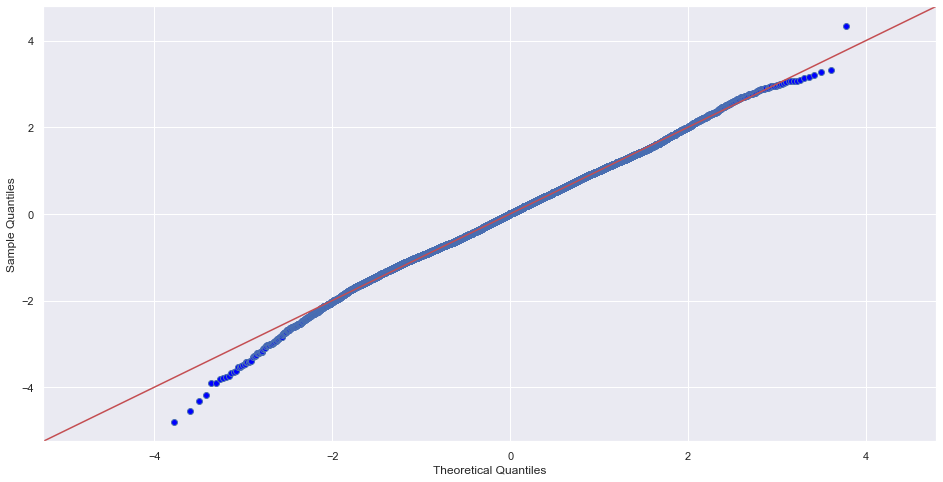

In [37]:
# checking normality
fig = sm.graphics.qqplot(model2.resid, dist=stats.norm, line='45', fit=True)

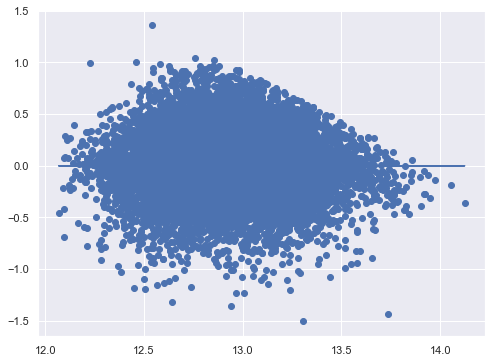

In [38]:
#Check Homoscedasticity Assumption
plt.figure(figsize = (8,6))
plt.scatter(model2.predict(sm.add_constant(df_train[x_cols])), model2.resid)
plt.plot(model2.predict(sm.add_constant(df_train[x_cols])), [0 for i in range(len(df_train[x_cols]))])

In [39]:
# model2 seems pretty good in terms of normality, Homoscedasticity, and R-squared values

# Evaluation

In [40]:
from sklearn.linear_model import LinearRegression

final_model = LinearRegression()
# Fit the model on X_train_final and y_train
final_model.fit(df_train[x_cols], df_train[outcome])

# Score the model on X_test_final and y_test
# (use the built-in .score method)
print( "Test score:  ", final_model.score(df_test[x_cols], df_test[outcome]))
print( "Train score: ", final_model.score(df_train[x_cols], df_train[outcome]))

Test score:   0.44378007421545485
Train score:  0.44859642929281374


In [41]:
# use cross validation to evaluate the model
from sklearn.model_selection import cross_validate, ShuffleSplit
splitter = ShuffleSplit(n_splits=3, test_size=0.25, random_state=0)
baseline_scores = cross_validate(
    estimator = final_model,
    X= df[x_cols],
    y= df[outcome],
    return_train_score=True,
    cv=splitter
)
print("Train score:     ", baseline_scores["train_score"].mean())
print("Validation score:", baseline_scores["test_score"].mean())

Train score:      0.44648159473484395
Validation score: 0.4500640604866031


In [42]:
# train and validation scores are similar

In [43]:
# check mean squared error, root mean squared error, and Mean absolute error
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import r2_score
import math
print("MSE:       ", mean_squared_error(df_test[outcome], final_model.predict(df_test[x_cols])))
print("RMSE:      ", math.sqrt(mean_squared_error(df_test[outcome], final_model.predict(df_test[x_cols]))))
print("MAE:       ", mean_absolute_error(df_test[outcome], final_model.predict(df_test[x_cols])))
print("R-Squared: ", r2_score(df_test[outcome], final_model.predict(df_test[x_cols])))


MSE:        0.10077497430795615
RMSE:       0.3174507431208126
MAE:        0.251980604965677
R-Squared:  0.44378007421545485


Text(0, 0.5, '(Predicted Price - actual price)/actual price * 100')

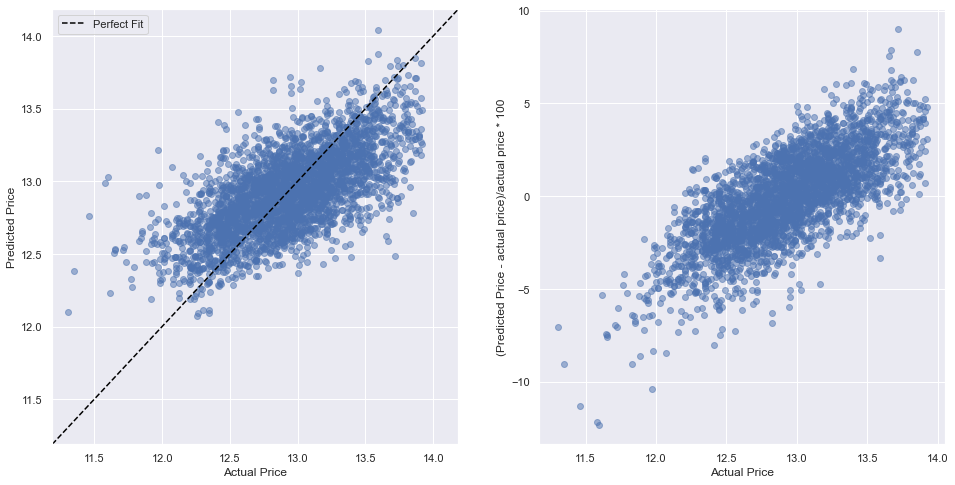

In [44]:
# visualization of real and predicted values for each value
preds = final_model.predict(df_test[x_cols])
fig, axs = plt.subplots(1,2, figsize =(16,8))
perfect_line = np.arange(min(preds.min(),df_test[outcome].min())*0.99, max(preds.max(),df_test[outcome].max())*1.1)
axs[0].plot(perfect_line,perfect_line, linestyle="--", color="black", label="Perfect Fit")
axs[0].scatter(df_test[outcome], preds, alpha=0.5)
axs[0].set_xlabel("Actual Price")
axs[0].set_ylabel("Predicted Price")
axs[0].legend();
axs[0].set_xlim([min(preds.min(),df_test[outcome].min())*0.99, max(preds.max(),df_test[outcome].max())*1.01])
axs[0].set_ylim([min(preds.min(),df_test[outcome].min())*0.99, max(preds.max(),df_test[outcome].max())*1.01])
axs[1].scatter(df_test[outcome], np.divide((df_test[outcome] - preds),df_test[outcome]) * 100, alpha=0.5)
axs[1].set_xlabel("Actual Price")
axs[1].set_ylabel("(Predicted Price - actual price)/actual price * 100")

In [45]:
# From above values and plots, the fitted regression model can predict house price very well

# Summary about the model

In [46]:
# the beta coefficients
print(pd.Series(final_model.coef_, index=x_cols, name="Coefficients"))
print()
print("Intercept:", final_model.intercept_)

sqft_lot            0.001943
sqft_living15       1.096717
sqft_lot15         -0.144789
bedrooms_3          0.083760
bedrooms_4          0.149979
bedrooms_5          0.163189
floors_2.5          0.226109
floors_3.0          0.056801
waterfront_1.0      0.398927
is_renovated_1.0    0.192348
view_1.0            0.137734
view_2.0            0.148326
view_3.0            0.117277
view_4.0            0.243554
grade_10            0.258860
grade_11            0.418129
zipcode4_98020     -0.112151
zipcode4_98030     -0.086005
zipcode4_98040     -0.156698
zipcode4_98060     -0.055208
zipcode4_98070      0.128485
zipcode4_98090     -0.420847
zipcode4_98100      0.304544
zipcode4_98110      0.355810
zipcode4_98120      0.233377
zipcode4_98130      0.149527
zipcode4_98150      0.056281
zipcode4_98160     -0.225556
zipcode4_98170     -0.097728
zipcode4_98180     -0.279241
Name: Coefficients, dtype: float64

Intercept: 12.30344679761995


## From coefficients described above, I observed:
### 1) The grade and sqft_living15 have the strongest relationship with the house price
### 2) It is interesting to see the sqft_lot15 has the negative relationship with the house price
### 3) Waterfront_1.0 and grade_11 also have postive relationship with the price
### 4) For some zipcode, e.g., 98100 and 98110, they have high positive relationship with the price

## To address the business question:
### 1) For buyer, they will know the house price is higher for a house with high grade and sqrt_living15
### 2) For seller, if they want to sell their house with a higher price, they could add waterfront, improve the grade.
